In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from math import ceil, prod
import matplotlib.pyplot as plt
import numpy as np
import torch

from model import *

np.random.seed(42)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

Device: cuda:0


# Load Data

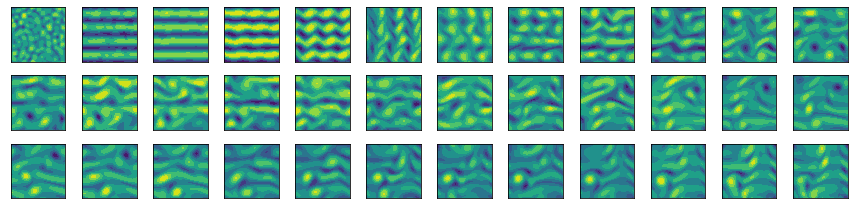

In [3]:
# Load data
vorticity_snapshots = []
for i in range(200):
    binary = open(f'./turbulence_data/vortJP_0000.{str(i).zfill(3)}', 'rb')
    binary.seek(0)
    snap = np.fromfile(binary, dtype='float64', count=128**2).reshape(128, 128)
    vorticity_snapshots.append(snap)

# Visualize select snapshots
axis_array = 2 * [np.linspace(0, 2 * np.pi, 128)]
fig_shape = (3, 12)
fig = plt.figure(figsize=fig_shape[::-1])
for i in range(prod(fig_shape)):
    ax = fig.add_subplot(*fig_shape, i+1)
    ax.contourf(*axis_array, vorticity_snapshots[i])
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
plt.show()

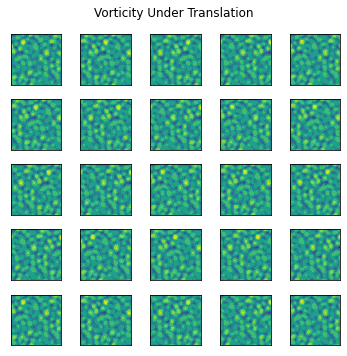

In [4]:
# Translate snapshots
def translate(snapshot, movement_vector):
    scaled_movement = [int(128 * x / (2 * np.pi)) for x in movement_vector]
    return np.roll(snapshot, scaled_movement)

# Visualize shift
axis_array = 2 * [np.linspace(0, 2 * np.pi, 128)]
fig_shape = (5, 5)
fig = plt.figure(figsize=fig_shape[::-1])
for i in range(prod(fig_shape)):
    ax = fig.add_subplot(*fig_shape, i+1)
    translate_vector = [(np.pi / 2) * x for x in (i % fig_shape[1], i // fig_shape[1])]
    snap = translate(vorticity_snapshots[0], translate_vector)
    ax.contourf(*axis_array, snap)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.set_title('; '.join([f'{x:.02f}' for x in translate_vector]))
fig.suptitle('Vorticity Under Translation')
fig.tight_layout()
plt.show()

In [5]:
snapshots = torch.Tensor(vorticity_snapshots).unsqueeze(1)
snapshots /= snapshots.absolute().max()

C:\Users\thema\AppData\Local\Temp\ipykernel_12636\1109729755.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:210.)
  snapshots = torch.Tensor(vorticity_snapshots).unsqueeze(1)


# Train

In [6]:
epochs = 101
batch_size = 32
epoch_pd = 10

In [7]:
autoencoder = AEModel(embedded_dim=8).to(device)
optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=.001)
criterion = nn.MSELoss()

In [8]:
autoencoder.train()
batches = ceil(len(snapshots) / batch_size)
for epoch in range(epochs):
    for _ in range(batches):
        batch = snapshots[np.random.choice(range(len(snapshots)), batch_size)].to(device)
        _, logits = autoencoder(batch)
        loss = criterion(logits, batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % epoch_pd == 0:
        print(f'Epoch: {epoch} \tLoss:{float(loss.detach())}')

Epoch: 0 	Loss:0.03973698243498802
Epoch: 10 	Loss:0.022280484437942505
Epoch: 20 	Loss:0.01625039614737034
Epoch: 30 	Loss:0.017966002225875854
Epoch: 40 	Loss:0.009820178151130676
Epoch: 50 	Loss:0.01098150946199894
Epoch: 60 	Loss:0.008593043312430382
Epoch: 70 	Loss:0.009089075028896332
Epoch: 80 	Loss:0.008820032700896263
Epoch: 90 	Loss:0.007402176968753338
Epoch: 100 	Loss:0.005496252328157425


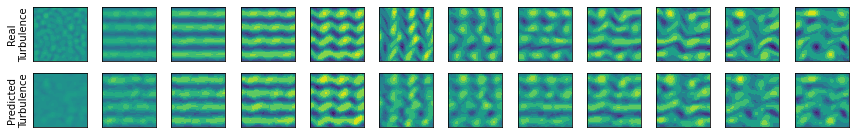

In [11]:
# Preview reconstruction
axis_array = 2 * [np.linspace(0, 2 * np.pi, 128)]
fig_shape = (2, 12)
fig = plt.figure(figsize=fig_shape[::-1])
for i in range(fig_shape[1]):
    # Actual
    ax = fig.add_subplot(*fig_shape, i+1)
    ax.contourf(*axis_array, snapshots[i, 0, :, :], vmin=-1, vmax=1)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    if i == 0:
        ax.set_ylabel('Real\nTurbulence')
    
    # Predicted
    ax = fig.add_subplot(*fig_shape, fig_shape[1]+i+1)
    ax.contourf(*axis_array, autoencoder(snapshots[[i]].to(device))[1].detach().cpu()[0, 0, :, :], vmin=-1, vmax=1)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    if i == 0:
        ax.set_ylabel('Predicted\nTurbulence')
fig.tight_layout()
plt.show()